Based on: https://github.com/jeffheaton/t81_558_deep_learning


## Generating High Rez GAN Faces with Google CoLab

This notebook demonstrates how to run [NVidia StyleGAN3](https://github.com/NVlabs/stylegan3) inside a Google CoLab notebook.  I suggest you use this to generate GAN faces from a pretrained model.  If you try to train your own, you will run into compute limitations of Google CoLab. Make sure to run this code on a GPU instance.  GPU is assumed.

First, we clone StyleGAN3 from GitHub.

In [ ]:
# HIDE OUTPUT
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.16 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 8.2 MB/s 



Verify that StyleGAN has been cloned.

In [ ]:
!ls /content/stylegan3

avg_spectra.py	 Dockerfile	  gen_video.py	metrics      train.py
calc_metrics.py  docs		  gui_utils	README.md    visualizer.py
dataset_tool.py  environment.yml  legacy.py	torch_utils  viz
dnnlib		 gen_images.py	  LICENSE.txt	training


## Run StyleGAN From Python Code

Add the StyleGAN folder to Python so that you can import it.  

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', 
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


We can now generate images from integer seed codes in Python.

Seed 2000
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


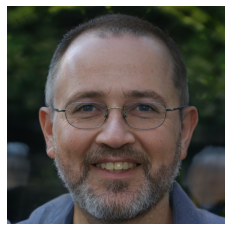

Seed 2001


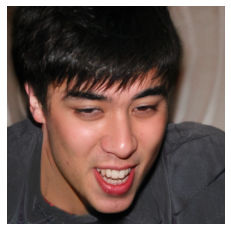

Seed 2002


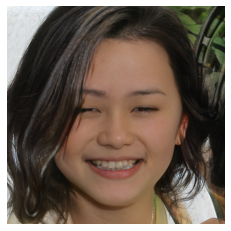

Seed 2003


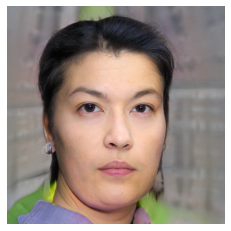

Seed 2004


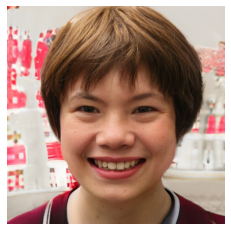

Seed 2005


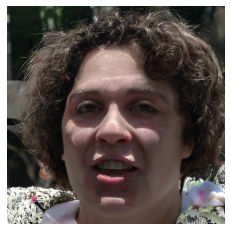

Seed 2006


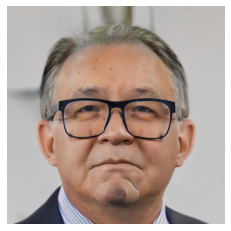

Seed 2007


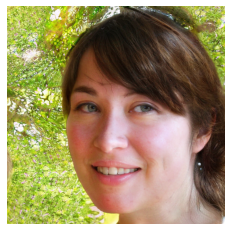

Seed 2008


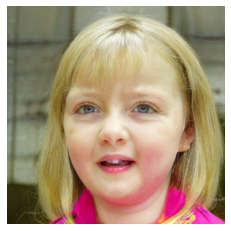

Seed 2009


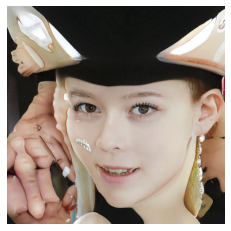

Seed 2010


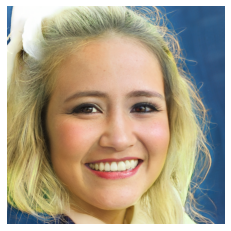

Seed 2011


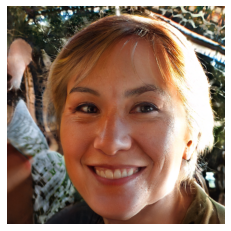

Seed 2012


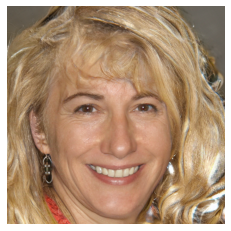

Seed 2013


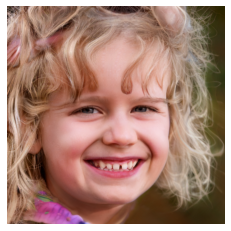

Seed 2014


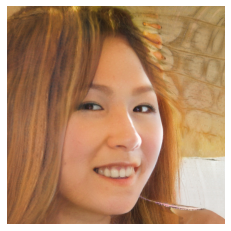

Seed 2015


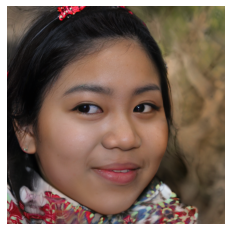

Seed 2016


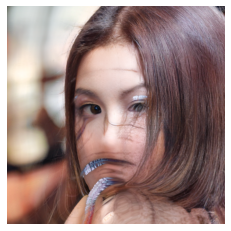

Seed 2017


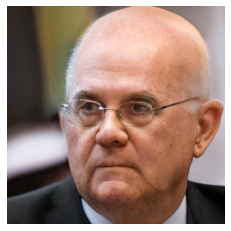

Seed 2018


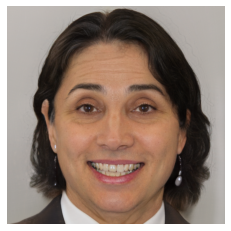

Seed 2019


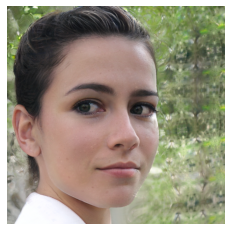

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 2000
SEED_TO = 2020

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

## Examining the Latent Vector

Figure 1 shows the effects of transforming the latent vector between two images. We accomplish this transformation by slowly moving one 512-value latent vector to another 512 vector. A high-dimension point between two latent vectors will appear similar to both of the two endpoint latent vectors. Images that have similar latent vectors will appear similar to each other.

**Figure 1: Transforming the Latent Vector**
![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.jpg "GAN")

In [ ]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [4021-1,4021+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
(1, 512)


The following code will move between the provided seeds.  The constant STEPS specify how many frames there should be between each seed.

In [ ]:
# HIDE OUTPUT
# Choose your seeds to morph through and the number of steps to 
# take to get to each.

SEEDS = [4021, 2002] # Better for faces
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

Seed 4021:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

You can now download the generated video.

In [ ]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Exercise 

Play around with the latent space representations and state at least 3 things (bullet points) that you found interesting (i.e. control for age, skin color, etc.)


1. When playing around with an image that had a hat on (4021), the shape of the hat usualy dictates the hair of the next couple of images.
2. Something really strange that i found is, when generating images of a person with a hat(4021). If the person weighs more and has more facial hair usually a wider hat or a fidora is generated with them, normal baseball caps are generated when the image represnts someone in an optimal weight range. e.g. overwight -> fidora, underweight -> baseballhat
3. When transitioning that same image into a woman, the hat is often converted into a beanie on a male before conferting into a full head of hair.


